<a href="https://colab.research.google.com/github/LukmaanViscomi/AI-Deep-Learning/blob/main/Baseline_Controlled_V5_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip The Data

In [ ]:
### Section 1: Setup and Dependencies
!apt-get install p7zip-full # Install 7-Zip
!pip install patool # Install the patool library which provides the patoolib module
import zipfile
import os
import patoolib # Now you can import patoolib

# Path to the uploaded zip file
zip_file_path = '/content/drive/MyDrive/dataset2 (1).zip'
extracted_folder_path = './dataset2'  # Use a relative path for the extraction directory

# Extract the zip file using patool
patoolib.extract_archive(zip_file_path, outdir=extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

### Section 2 : Inspecting the Original Dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.6 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO:patool:Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO patool: ... creating output directory `./dataset2'.
INFO:patool:... creating output directory `./dataset2'.
INFO patool: running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO:patool:running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.
INFO:patool:... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.


['triple_mnist']


### Redistribute The Dataset For Train/Val/Test

In [ ]:
#
import os
import shutil
from pathlib import Path
import random

# Paths to original directories
original_base_dir = Path('dataset2/triple_mnist')
original_train_dir = original_base_dir / 'train'
original_val_dir = original_base_dir / 'val'
original_test_dir = original_base_dir / 'test'

# Path to the new dataset directory
new_base_dir = Path('dataset-c/triple_mnist')
new_train_dir = new_base_dir / 'train'
new_val_dir = new_base_dir / 'val'
new_test_dir = new_base_dir / 'test'

# Ensure the new directories exist
new_train_dir.mkdir(parents=True, exist_ok=True)
new_val_dir.mkdir(parents=True, exist_ok=True)
new_test_dir.mkdir(parents=True, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, new_train_dir, new_val_dir, new_test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not src_dir.exists():
        return

    classes = sorted(os.listdir(src_dir))

    for cls in classes:
        cls_path = src_dir / cls
        if cls_path.is_dir():
            images = list(cls_path.glob('*'))
            random.shuffle(images)

            num_train = int(len(images) * train_ratio)
            num_val = int(len(images) * val_ratio)

            train_images = images[:num_train]
            val_images = images[num_train:num_train+num_val]
            test_images = images[num_train+num_val:]

            cls_train_dir = new_train_dir / cls
            cls_val_dir = new_val_dir / cls
            cls_test_dir = new_test_dir / cls

            cls_train_dir.mkdir(parents=True, exist_ok=True)
            cls_val_dir.mkdir(parents=True, exist_ok=True)
            cls_test_dir.mkdir(parents=True, exist_ok=True)

            for img in train_images:
                shutil.copy(str(img), str(cls_train_dir / img.name))
            for img in val_images:
                shutil.copy(str(img), str(cls_val_dir / img.name))
            for img in test_images:
                shutil.copy(str(img), str(cls_test_dir / img.name))

# Split and copy files from original train, val, and test directories
split_and_copy_files(original_train_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_val_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_test_dir, new_train_dir, new_val_dir, new_test_dir)

print("Files split and copied successfully!")

Files split and copied successfully!


### Imports and Initial Setup -Define Directory

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight



### Data Generators for the Subset

In [ ]:
# Define directories for training, validation, and testing datasets
train_dir = os.path.join('/content/dataset-c/triple_mnist/train')
val_dir = os.path.join('/content/dataset-c/triple_mnist/val')
test_dir = os.path.join('/content/dataset-c/triple_mnist/test')

# Image size and batch size
image_size = (42, 42)
batch_size = 32

# Create ImageDataGenerator with color_mode set to 'grayscale'
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images with 'grayscale' mode
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

Found 84089 images belonging to 1000 classes.
Found 36018 images belonging to 1000 classes.
Found 36003 images belonging to 1000 classes.


### Build the model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         129,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 812,392 (3.10 MB)

 Trainable params: 811,944 (3.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2628/2628 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - accuracy: 0.0480 - loss: 6.0731 - val_accuracy: 0.7982 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.6701 - loss: 1.1998 - val_accuracy: 0.7872 - val_loss: 0.7363 - learning_rate: 0.0010
Epoch 3/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.8036 - loss: 0.6572 - val_accuracy: 0.9300 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 4/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.8377 - loss: 0.5297 - val_accuracy: 0.9404 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 5/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.8608 - loss: 0.4520 - val_accuracy: 0.9451 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 6/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.8690 - loss: 0.4115 - val_accuracy: 0.9092 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 7/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.8847 

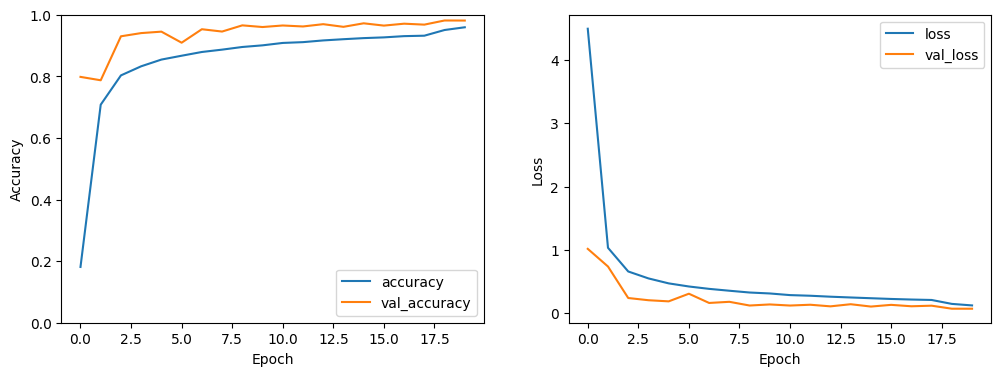

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9810 - loss: 0.0690
Test accuracy: 0.9806960821151733


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize the model
cnn_model = Sequential()

# First convolutional layer with Leaky ReLU and Batch Normalization
cnn_model.add(Conv2D(32, (3, 3), input_shape=(42, 42, 1)))  # Note the change to 1 channel
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(MaxPooling2D((2, 2)))

# Second convolutional layer with Leaky ReLU and Batch Normalization
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(MaxPooling2D((2, 2)))

# Fully connected layer with Leaky ReLU, Batch Normalization, and Dropout
cnn_model.add(Flatten())
cnn_model.add(Dense(128))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
cnn_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print the model summary
cnn_model.summary()

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=20,  # You can increase this if needed
    validation_data=val_generator,  # Use the separate validation data
    class_weight=class_weights,  # Use class weights if needed
    callbacks=[lr_scheduler, early_stopping]
)

# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
